# XPCS&XSVS Pipeline for Single-(Gi)-SAXS Run
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

### DEV
* V8: Update visbility error bar calculation using pi = his/N +/- sqrt(his_i)/N
*     Update normlization in g2 calculation uing 2D-savitzky golay (SG ) smooth

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [2]:
from pyCHX.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *
import itertools
from pyCHX.SAXS import poly_sphere_form_factor_intensity

In [3]:
#%matplotlib notebook
%matplotlib inline

## Control Runs Here

In [4]:
#scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'ang_saxs' 
#scat_geometry = 'gi_waxs' 
scat_geometry = 'gi_saxs'


roi_auto =  False #True #False #True #if True, will automatically create a roi based on the roi_type ( iso/aniso etc), currently only works for SAXS
fit_peak = False #True

analysis_type_auto = False #True #if True, will take "analysis type" option from data acquisition func series
qphi_analysis =  False #True #False  #if True, will do q-phi (anisotropic analysis for transmission saxs)

isotropic_Q_mask = 'normal' #'wide' # 'normal' # 'wide'  ## select wich Q-mask to use for rings: 'normal' or 'wide'
phi_Q_mask = 'phi_4x_20deg'   ## select wich Q-mask to use for phi analysis
q_mask_name = ''

force_compress = False #True   #force to compress data 
bin_frame = False   #generally make bin_frame as False
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall =  False #True #False #True   #run waterfall analysis
run_profile_plot = True #False  #run prolfile plot for gi-saxs
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_get_mass_center = False  # Analysis for mass center of reflective beam center
run_invariant_analysis = False
run_one_time =  True  #run  one-time
cal_g2_error =  False  #True  #calculate g2 signal to noise
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time =   False #True    #run  two-time
run_four_time = False #True #True #False   #run  four-time
run_xsvs= False # True #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 7 #the intested single qth     

use_sqnorm = True    #if True, use sq to normalize intensity
use_SG = False #True # False        #if True, use the Sawitzky-Golay filter of the avg_img for normalization
use_SG_bin_frames =  True   #if True, use the Sawitzky-Golay filter of the (binned) frame for normalization 

use_imgsum_norm= True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_%s'%get_today_date()     #for pdf report name
run_dose = False # True # False #True # True #False  #run dose_depend analysis


if scat_geometry == 'gi_saxs':run_xsvs= False;use_sqnorm=False
if scat_geometry == 'gi_waxs':use_sqnorm = False
if scat_geometry != 'saxs':qphi_analysis = False;scat_geometry_ = scat_geometry;roi_auto = False  
else:scat_geometry_ = ['','ang_'][qphi_analysis]+ scat_geometry   
if scat_geometry != 'gi_saxs':run_profile_plot = False

In [5]:
scat_geometry, scat_geometry_, qphi_analysis

('gi_saxs', 'gi_saxs', False)

In [6]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None; lag_steps = None 

## Make a directory for saving results

In [7]:
CYCLE= '2019_2'  #change clycle here
path = '/XF11ID/analysis/%s/masks/'%CYCLE

## Load Metadata & Image Data



### Change this line to give a uid

In [8]:
username      =  getpass.getuser()
uid = '887b6b5d'
uid = 'b5e319df' #] (scan num: 19486) (Measurement: test contrast and stabilityPM20190808_Ge_250C )


print(uid)
username = 'pmyint'

roi_auto = False # True #False #True #if True, will automatically create a roi based on the roi_type ( iso/aniso etc), currently only works for SAXS
run_two_time  =   True 
run_dose      =   False 



b5e319df


 # put the uid below 

In [9]:


# Parameters
uid = "e2bc7f37"
username = "pmyint"
run_two_time = True
run_dose = False


In [10]:
print(uid)

e2bc7f37


In [11]:
#db[-1]

In [12]:
#get_last_uids( -2)

In [13]:
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2019_2/pmyint/Results/
/XF11ID/analysis/2019_2/pmyint/Results/


In [14]:
uid = uid[:8]
print('The current uid for analysis is: %s...'%uid)

The current uid for analysis is: e2bc7f37...


In [15]:
sud = get_sid_filenames(db[uid])
for pa in sud[2]:
    if 'master.h5' in pa:
        data_fullpath = pa
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], data_fullpath ))

#start_time, stop_time = '2017-2-24  12:23:00', '2017-2-24  13:42:00' 
#sids, uids, fuids  = find_uids(start_time, stop_time)

filepath : /nsls2/xf11id1/data/2019/08/17/48451e1a-d4dd-4eec-acc7
got images_per_file
scan_id, full-uid, data path are:  19628--e2bc7f37-8f95-4f18-8465-af91a8e58bf4--/nsls2/xf11id1/data/2019/08/17/48451e1a-d4dd-4eec-acc7_6735_master.h5


In [16]:
data_dir = os.path.join(data_dir0, '%s/'%(sud[1]))
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2019_2/pmyint/Results/e2bc7f37-8f95-4f18-8465-af91a8e58bf4/


# Don't Change the lines below here

* get metadata

In [17]:
md = get_meta_data( uid )
md_blue = md.copy()
#md_blue

In [18]:
#md_blue['detectors'][0]
#if md_blue['OAV_mode'] != 'none':
#    cx , cy = md_blue[md_blue['detectors'][0]+'_beam_center_x'], md_blue[md_blue['detectors'][0]+'_beam_center_x']
#else: 
#    cx , cy = md_blue['beam_center_x'], md_blue['beam_center_y']
#print(cx,cy)

In [19]:
detectors = sorted(get_detectors(db[uid]))
print('The detectors are:%s'%detectors)
if len(detectors) >1:
    md['detector'] = detectors[1]
    print( md['detector'])


The detectors are:['eiger4m_single_image']


In [20]:
if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    reverse= True
    rot90= False
elif md['detector'] =='eiger500K_single_image':    
    reverse= True
    rot90=True
elif md['detector'] =='eiger1m_single_image':    
    reverse= True
    rot90=False
print('Image reverse: %s\nImage rotate 90: %s'%(reverse, rot90))    

Image reverse: True
Image rotate 90: False


In [21]:
try:
    cx , cy = md_blue['beam_center_x'], md_blue['beam_center_y']
    print(cx,cy)
except:
    print('Will find cx,cy later.')


Will find cx,cy later.


### Load ROI defined by "XPCS_Setup" Pipeline

#### Define data analysis type

In [22]:
if analysis_type_auto:#if True, will take "analysis type" option from data acquisition func series
    try:
        if scat_geometry != 'gi_saxs':
            qphi_analysis_ = md['analysis'] #if True, will do q-phi (anisotropic analysis for transmission saxs)
            print(md['analysis'])
            if qphi_analysis_ == 'iso':
                qphi_analysis = False
            elif qphi_analysis_ == '':
                qphi_analysis = False
            else:
                qphi_analysis = True
            #for other analysis type, in case of GiSAXS, low_angle/high_anlge for instance    
        else:
            gisaxs_inc_type = md['analysis'] 
        
    except:
        gisaxs_inc_type = None
        print('There is no analysis in metadata.')
        
print('Will %s qphis analysis.'%['NOT DO','DO'][qphi_analysis]) 

if scat_geometry != 'saxs':qphi_analysis = False;scat_geometry_ = scat_geometry  
else:scat_geometry_ = ['','ang_'][qphi_analysis]+ scat_geometry   
if scat_geometry != 'gi_saxs':run_profile_plot = False     
    
print(scat_geometry_)    

Will NOT DO qphis analysis.
gi_saxs


In [23]:
scat_geometry

'gi_saxs'

In [24]:
#%run /home/yuzhang/pyCHX_link/pyCHX/chx_generic_functions.py

* get data

In [25]:
imgs = load_data( uid, md['detector'], reverse= reverse, rot90=rot90  )
md.update( imgs.md );Nimg = len(imgs);
#md['beam_center_x'], md['beam_center_y']  = cx, cy
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

#md['acquire period' ] = md['cam_acquire_period']
#md['exposure time'] =  md['cam_acquire_time']
mdn = md.copy()


The data are: Pipeline processed through proc_func. Original repr:
    EigerImages processed through proc_func. Original repr:
        <Frames>
        Length: 5160 frames
        Frame Shape: 2167 x 2070
        Pixel Datatype: uint32


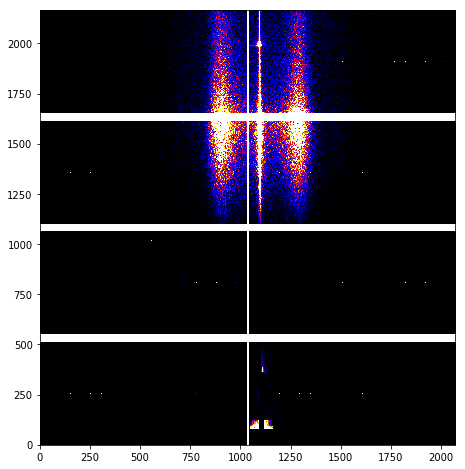

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(imgs[1000],vmin=1e-3,vmax=50,cmap=cmap_vge)

#### Load Chip mask depeding on detector

In [27]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
    BadPix =     np.load('/XF11ID/analysis/2018_1/BadPix_4M.npy'  )  
    Chip_Mask.ravel()[BadPix] = 0
elif md['detector'] =='eiger500K_single_image':
    #print('here')
    Chip_Mask=  np.load( '/XF11ID/analysis/2017_1/masks/Eiger500K_Chip_Mask.npy')  #to be defined the chip mask
    Chip_Mask = np.rot90(Chip_Mask)
    pixel_mask = np.rot90(  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool))   )
    
else:
    Chip_Mask = 1
print(Chip_Mask.shape, pixel_mask.shape)

(2167, 2070) (2167, 2070)


In [28]:
use_local_disk = True
import shutil,glob

In [29]:
save_oavs = False
if len(detectors)==2:
    if '_image' in md['detector']:
        pref = md['detector'][:-5]
    else:
        pref=md['detector']
    for k in [ 'beam_center_x', 'beam_center_y','cam_acquire_time','cam_acquire_period','cam_num_images',
             'wavelength', 'det_distance', 'photon_energy']:
        md[k] =  md[ pref + '%s'%k]    
    
    if 'OAV_image' in detectors:
        try:
            save_oavs_tifs(  uid, data_dir )
            save_oavs = True
        except:
            pass
        

In [30]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> e2bc7f37
number of images--> 5160
uid--> e2bc7f37-8f95-4f18-8465-af91a8e58bf4
scan_id--> 19628
start_time--> 2019-08-17 18:55:03
stop_time--> 2019-08-17 19:38:05
sample--> PM20190817-2
Measurement--> 0 degree bombardment on fresh sample at 300C temperature ----- more water flow_with beam position feedback on. no shutter sample rotated 45degPM20190817-2
acquire period--> 0.5
exposure time--> 0.5
beam_center_x--> 1100.0
beam_center_y--> 2089.0


## Overwrite Some Metadata if Wrong Input

### Define incident beam center (also define reflection beam center for gisaxs)

In [31]:
if scat_geometry =='gi_saxs':
    
    inc_x0 = md['beam_center_x'] 
    inc_y0 =  imgs[0].shape[0] - md['beam_center_y']    
    
    refl_x0 =    md['beam_center_x'] 
    #inc_ang = 0.39
    #refl_y0 =     1780 #1000     #imgs[0].shape[0] -  1758      
    #refl_x0 =     md['beam_center_x']  
    inc_ang  =   abs(  float(db[uid]['start']['inc_angle'] ))
    #print(inc_ang)
    refl_x0, refl_y0 = inc_x0,  np.tan(2* np.radians(inc_ang))*md['eiger4m_single_det_distance']/0.075*1e3  + inc_y0
    
    #%run -i ~/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/XPCS_GiSAXS.py
    #refl_x0, refl_y0 = get_refl_xy(  inc_ang= inc_ang, inc_phi=0, inc_x0= inc_x0, inc_y0= inc_y0, pixelsize=[0.075,0.075], Lsd= md['det_distance']*1000   )
  
   
    print( "inc_x0, inc_y0, ref_x0,ref_y0 are: %s %s %s %s."%(inc_x0, inc_y0, refl_x0, refl_y0) )
else:
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image' or md['detector']=='eiger1m_single_image':    
        inc_x0 =  imgs[0].shape[0] - md['beam_center_y']   
        inc_y0=   md['beam_center_x']
    elif md['detector'] =='eiger500K_single_image':    
        inc_y0 =  imgs[0].shape[1] - md['beam_center_y']   
        inc_x0 =   imgs[0].shape[0] - md['beam_center_x']
    
    print(inc_x0, inc_y0)

    ###for this particular uid, manually give x0/y0
    #inc_x0 = 1041
    #inc_y0 = 1085

inc_x0, inc_y0, ref_x0,ref_y0 are: 1100.0 78.0 1100.0 1953.7905556755372.


In [32]:
md

{'suid': 'e2bc7f37',
 'filename': '/nsls2/xf11id1/data/2019/08/17/48451e1a-d4dd-4eec-acc7_6735_master.h5',
 'detector': 'eiger4m_single_image',
 'eiger4m_single_cam_acquire_period': 0.5,
 'eiger4m_single_cam_acquire_time': 0.49999698996543884,
 'eiger4m_single_cam_num_images': 5160,
 'eiger4m_single_beam_center_x': 1100.0,
 'eiger4m_single_beam_center_y': 2089.0,
 'eiger4m_single_wavelength': 1.2848103046417236,
 'eiger4m_single_det_distance': 10.333484865000003,
 'eiger4m_single_threshold_energy': 6400.0,
 'eiger4m_single_photon_energy': 9650.0,
 'eiger4m_single_stats1_configuration_names': ['eiger4m_single_stats1_configuration_names',
  'eiger4m_single_stats1_port_name',
  'eiger4m_single_stats1_asyn_pipeline_config',
  'eiger4m_single_stats1_blocking_callbacks',
  'eiger4m_single_stats1_enable',
  'eiger4m_single_stats1_nd_array_port',
  'eiger4m_single_stats1_plugin_type',
  'eiger4m_single_stats1_bgd_width',
  'eiger4m_single_stats1_centroid_threshold',
  'eiger4m_single_stats1_co

In [33]:
dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )
if scat_geometry =='gi_saxs':center=center[::-1]
if uid == '4740b6b5-20cb-4ad1-9f7a-b7a2b3a77659':
    Ldet =  16.035*1000
    
#Ldet = 10.36*1e3
    
setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)
print_dict( setup_pargs )


Beam_center_x has been changed to 78.0. (no change in raw metadata): 
Beam_center_y has been changed to 1100.0.  (no change in raw metadata): 
uid--> uid=e2bc7f37
dpix--> 0.07500000356230885
Ldet--> 10333.499908447266
lambda_--> 1.2848103
exposuretime--> 0.499997
timeperframe--> 0.5
center--> [78, 1100]
path--> /XF11ID/analysis/2019_2/pmyint/Results/e2bc7f37-8f95-4f18-8465-af91a8e58bf4/


In [34]:
setup_pargs

{'uid': 'uid=e2bc7f37',
 'dpix': 0.07500000356230885,
 'Ldet': 10333.499908447266,
 'lambda_': 1.2848103,
 'exposuretime': 0.499997,
 'timeperframe': 0.5,
 'center': [78, 1100],
 'path': '/XF11ID/analysis/2019_2/pmyint/Results/e2bc7f37-8f95-4f18-8465-af91a8e58bf4/'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change the lines below to give mask filename

In [35]:
date = 'Aug15'


if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2019_2/masks/'    
    mask_name =  '%s_2019_4M_GiSAXS.npy'%date
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2019_3/masks/'
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
        mask_name = '%s_2019_4M_SAXS.npy'%date   
        
    elif md['detector'] =='eiger500K_single_image':    
        mask_name = '%s_2019_500K_SAXS.npy'%date    
        
elif scat_geometry == 'gi_waxs':    
    mask_path = '/XF11ID/analysis/2019_3/masks/'    
    mask_name =  '%s_2019_1M_WAXS.npy'  
    

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


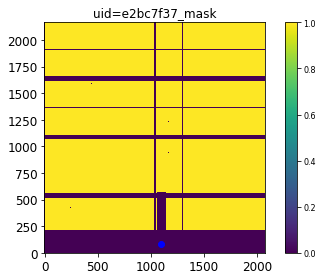

In [36]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= reverse, rot90=rot90  ) 
mask =  mask * pixel_mask * Chip_Mask
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1, center=center[::-1])
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Check several frames average  intensity

#### Load ROI mask depending on data analysis type

In [37]:
#%run ~/pyCHX_link/pyCHX/chx_generic_functions.py

In [38]:
print(roi_auto, qphi_analysis, isotropic_Q_mask)

False False normal


In [39]:
##For SAXS 
roi_path = '/XF11ID/analysis/2019_3/masks/'
roi_date = 'Aug10'
#roi_date = 'May30B'


if scat_geometry =='saxs':
    ## For auto load roi mask
    if roi_auto: 
        general_path = '/nsls2/xf11id1/analysis/2017_1/masks/'
        roi_mask_norm = general_path + 'general_roi_mask_norm.npy' 
        roi_mask_wide = general_path + 'general_roi_mask_wide.npy' 
        roi_mask_phi_4x_20deg = general_path + 'general_roi_mask_phi_4x_20deg.npy' 
        roi_mask_12x_30deg = general_path + 'general_roi_mask_12x_30deg.npy' 
        roi_mask_12x_15deg_flow = general_path + 'general_roi_mask_12x_15deg_flow.npy'
        if qphi_analysis ==  False:
            if isotropic_Q_mask == 'normal':
                fp = roi_mask_norm
            elif isotropic_Q_mask == 'wide':
                fp = roi_mask_wide
        elif qphi_analysis:
            if phi_Q_mask == 'phi_4x_20deg':
                fp = roi_mask_phi_4x_20deg
            elif phi_Q_mask == 'phi_12x_30deg': 
                fp = roi_mask_phi_12x_30deg
            elif phi_Q_mask == 'phi_12x_15deg_flow': 
                fp = roi_mask_phi_12x_15deg_flow 
        roi_mask0 = np.load(fp)    
        old_cen=[4000,4000]        
        roi_mask, qval_dict, qwid_dict = get_roi_mask_qval_qwid_by_shift( 
                        new_cen=center, new_mask= mask, old_cen=old_cen,
                                    old_roi_mask=roi_mask0, limit_qnum= None,
                                    setup_pargs= setup_pargs,  geometry = scat_geometry_,
                                    ) 
 
    else: 
        if qphi_analysis ==  False:
            if isotropic_Q_mask == 'normal':
                #print('Here')
                q_mask_name='rings'
                if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M 
                    fp = roi_path + 'roi_mask_%s_4M_norm.pkl'%roi_date                 

                elif md['detector'] =='eiger500K_single_image': #for 500K   
                    fp = roi_path + 'roi_mask_%s_500K_norm.pkl'%roi_date   


            elif isotropic_Q_mask == 'wide':
                q_mask_name='wide_rings'
                if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M   
                    fp = roi_path + 'roi_mask_%s_4M_wide.pkl'%roi_date   
                elif md['detector'] =='eiger500K_single_image': #for 500K   
                    fp = roi_path + 'roi_mask_%s_500K_wide.pkl'%roi_date   


        elif qphi_analysis:
            if phi_Q_mask =='phi_4x_20deg':
                q_mask_name='phi_4x_20deg'
                if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M 
                    fp = roi_path + 'roi_mask_%s_4M_phi_4x_20deg.pkl'%roi_date   
                elif md['detector'] =='eiger500K_single_image': #for 500K 
                    fp = roi_path + 'roi_mask_%s_500K_phi_4x_20deg.pkl'%roi_date   


        #fp = 'XXXXXXX.pkl'            
        roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
        print(fp)

## Gi_SAXS 
elif scat_geometry =='gi_saxs': 
    
    # static mask    
    #ss =  '887b6b5d'
    ss =   '28d8f37c'
    
    
    fp = '/XF11ID/analysis/2019_2/masks/uid=%s_roi_masks.pkl'%ss
    roi_masks,qval_dicts = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data    
    print('The static mask is: %s.'%fp)    

    fp = '/XF11ID/analysis/2019_2/masks/uid=%s_roi_mask.pkl'%(ss)
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
    print('The dynamic mask is: %s.'%fp)
    # q-map
    fp = '/XF11ID/analysis/2019_2/masks/uid=%s_qmap.pkl'%(ss)
    #print(fp)
    qr_map, qz_map, ticks, Qrs, Qzs,  Qr, Qz, inc_x0,refl_x0, refl_y0 = cpk.load( open(fp, 'rb' )  )
    print('The qmap is: %s.'%fp)
    
## WAXS 
elif scat_geometry =='gi_waxs': 
    #fp = '/XF11ID/analysis/2019_1/masks/uid=ca2ccb14_roi_mask_5PTO_130C_PTO.pkl'     
    fp =  '/XF11ID/analysis/2019_2/masks/uid=278c0df1_roi_mask.pkl'
    
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data

print(roi_mask.shape)

The static mask is: /XF11ID/analysis/2019_2/masks/uid=28d8f37c_roi_masks.pkl.
The dynamic mask is: /XF11ID/analysis/2019_2/masks/uid=28d8f37c_roi_mask.pkl.
The qmap is: /XF11ID/analysis/2019_2/masks/uid=28d8f37c_qmap.pkl.
(2167, 2070)


In [40]:
#qval_dict

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


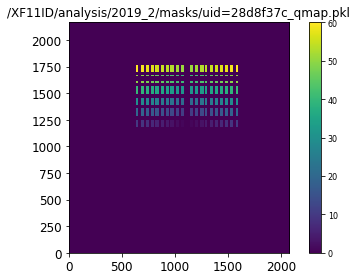

In [41]:
#roi_mask = shift_mask(roi_mask, 10,30)  #if shift mask to get new mask
show_img(roi_mask, aspect=1.0, image_name = fp)#, center=center[::-1])


In [42]:
img_choice_N = 1
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uidstr)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')


In [43]:
#show_img( imgsa[1000],  vmin=.1, vmax= 1e1, logs=True, aspect=1,
#         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )
print(center[::-1])

[1100, 78]


/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


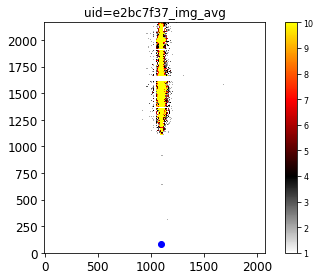

In [44]:
show_img( imgsa[ 5],  vmin = 1, vmax = 10, logs=False, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir, cmap=cmap_albula,center=center[::-1])
# select subregion, hard coded center beam location
#show_img( imgsa[180+40*3/0.05][110:110+840*2, 370:370+840*2],  vmin = 0.01, vmax = 20, logs=False, aspect=1, #save_format='tif',
#         image_name= uidstr + '_img_avg',  save=True, path=data_dir, cmap=cmap_albula,center=[845,839])

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [45]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.16035125030931696.
Will Always DO apply compress process.


In [46]:
if  md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    good_start =    5  #make the good_start at least 0
elif md['detector'] =='eiger500K_single_image': 
    good_start = 5#100  #5  #make the good_start at least 0
    
elif  md['detector'] =='eiger1m_single_image' or md['detector'] == 'image':    
    good_start =    5    

In [47]:
bin_frame =  False # True  #generally make bin_frame as False
if bin_frame:
    bin_frame_number=4
    acquisition_period = md['acquire period']
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

In [48]:
force_compress = False
#force_compress = True

Using already created compressed file with filename as :/nsls2/xf11id1/analysis/Compressed_Data/uid_e2bc7f37-8f95-4f18-8465-af91a8e58bf4.cmp.
The good_start frame number is: 5 
uid=e2bc7f37_fra_5_5160
Total time: 1.016 sec


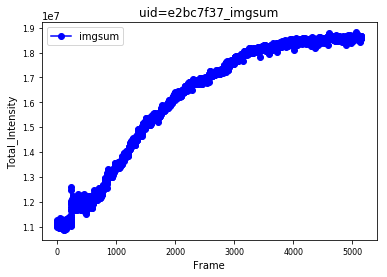

In [49]:
import time
t0= time.time()

if not use_local_disk:
    cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'
else:
    cmp_path = '/tmp_data/compressed'
    
    
cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'    
if bin_frame_number==1:   
    cmp_file = '/uid_%s.cmp'%md['uid']
else:
    cmp_file = '/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number)
    
filename = cmp_path + cmp_file  
mask2, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold = 1e14,
                                    reverse=reverse, rot90=rot90,
                        bins=bin_frame_number, num_sub= 100, num_max_para_process= 500, with_pickle=True,
                        direct_load_data =use_local_disk, data_path = data_fullpath, )                                  
                                                         
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)

FD = Multifile(filename, good_start, len(imgs)//bin_frame_number )
#FD = MultifileBNLCustom(filename, good_start, len(imgs)//bin_frame_number )

###For test purpose to use the first 1000 frames
####################################################################
#FD = MultifileBNLCustom(filename, good_start, 500 )
#FD = Multifile(filename, good_start, 500)
############################################################


uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
Nimg = Nimg/bin_frame_number
run_time(t0)

mask2 =  mask * pixel_mask * Chip_Mask
mask_copy = mask.copy()
mask_copy2 = mask.copy()

avg_img *= mask

In [50]:
#%run ~/pyCHX_link/pyCHX/chx_generic_functions.py

In [51]:
try:
    if md['experiment']=='printing':
        #p = md['printing'] #if have this printing key, will do error function fitting to find t_print0
        find_tp0 = True
        t_print0 = ps(  y = imgsum[:400] ) * timeperframe
        print( 'The start time of print: %s.' %(t_print0  ) )
    else:
        find_tp0 = False
        print('md[experiment] is not "printing" -> not going to look for t_0')
        t_print0 = None
except:
    find_tp0 = False
    print('md[experiment] is not "printing" -> not going to look for t_0')
    t_print0 = None


md[experiment] is not "printing" -> not going to look for t_0


/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


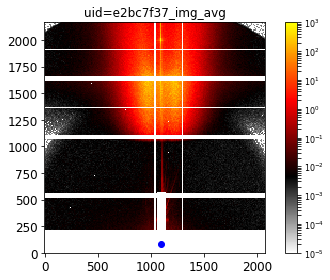

In [52]:
show_img( avg_img*mask,  vmin=1e-5, vmax= 1e3, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, 
         path=data_dir, center=center[::-1], cmap = cmap_albula )  #plt.cm.jet )#

## Get bad frame list by a polynominal fit

In [53]:
good_end= None # 2000  
if good_end is not None:
    FD = Multifile(filename, good_start, min( len(imgs)//bin_frame_number, good_end) )
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )
    

In [54]:
re_define_good_start =False
if re_define_good_start:
    good_start = 180
    #good_end = 19700
    good_end = len(imgs)
    FD = Multifile(filename, good_start, good_end) 
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( FD.beg, FD.end)

/nsls2/xf11id1/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/chx_generic_functions.py:2564: RankWarning: Polyfit may be poorly conditioned
  pol = np.polyfit(x, y, order)


The bad frame list length is: 51


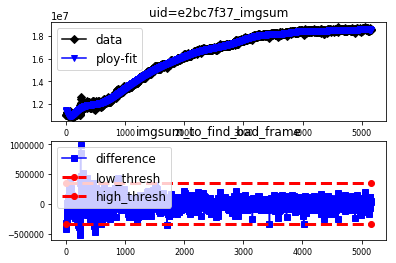

In [55]:
bad_frame_list =  get_bad_frame_list( imgsum, fit='both',  plot=True,polyfit_order = 30,                                      
                        scale= 3.5,  good_start = good_start, good_end=good_end, uid= uidstr, path=data_dir)

print( 'The bad frame list length is: %s'%len(bad_frame_list) )

### Creat new mask by masking the bad pixels and get new avg_img

In [56]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename=uidstr + '_img_sum_t', path= data_dir  )


### Plot time~ total intensity of each frame

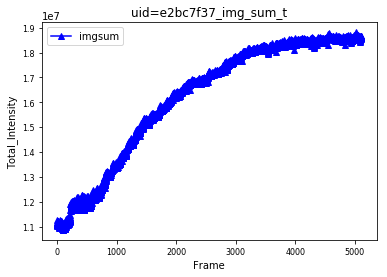

In [57]:
plot1D( y = imgsum_y, title = uidstr + '_img_sum_t', xlabel='Frame', c='b',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Get Dynamic Mask (currently designed for 500K)

In [58]:
if  md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    pass
elif md['detector'] =='eiger500K_single_image':  
    #if md['cam_acquire_period'] <= 0.00015:  #will check this logic
    if imgs[0].dtype == 'uint16':
        print('Create dynamic mask for 500K due to 9K data acquistion!!!')
        bdp = find_bad_pixels_FD( bad_frame_list, FD, img_shape = avg_img.shape, threshold=20 )    
        mask = mask_copy2.copy()
        mask *=bdp 
        mask_copy = mask.copy()
        show_img(  mask, image_name='New Mask_uid=%s'%uid )

# Static Analysis

## SAXS Scattering Geometry

In [59]:
setup_pargs 

{'uid': 'uid=e2bc7f37',
 'dpix': 0.07500000356230885,
 'Ldet': 10333.499908447266,
 'lambda_': 1.2848103,
 'exposuretime': 0.499997,
 'timeperframe': 0.5,
 'center': [78, 1100],
 'path': '/XF11ID/analysis/2019_2/pmyint/Results/e2bc7f37-8f95-4f18-8465-af91a8e58bf4/'}

In [60]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    mask = mask_copy.copy()
    hmask = create_hot_pixel_mask( avg_img, threshold = 1e8, center=center, center_radius= 10)
    
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img * Chip_Mask , mask * hmask, save=True,
                                                    pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs,  show_pixel=True,
                      xlim=[qp_saxs.min(), qp_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )
    mask =np.array( mask * hmask, dtype=bool) 

## SAXS to fit the form factor

In [61]:
#%run -i ~/pyCHX_link/pyCHX/SAXS.py

In [62]:
if scat_geometry =='saxs':    
    if run_fit_form:  
        qp, pq =  q_saxs, iq_saxs
        fitp, fitpe,   q_, fitq, result    = get_form_factor_fit_lmfit( qp, pq, 
            guess_values={'radius': 1180, 'sigma':0.05,'delta_rho':1e-9, 'background':5e-5,  
                          'qpower_scale':5e-10, 'qpower': -4.0 }, 
            guess_limit = { 'radius': [1000, 1500],   'sigma':[1e-3, .5], 'delta_rho': [1e-16, 1e-4], 
                           'background':  [1e-6, 1e-3], 'qpower_scale': [1e-16, 1], 'qpower': [ -5,-3]},                                                
            fit_range=[0.005, 0.03], 
            fit_variables={'radius': True,  'sigma':True,  'delta_rho':True,  'background': True,
                            'qpower_scale':True,  'qpower':False},
            fit_func='G',    qpower_bg= True  )
        
        r,sig=fitp[ 'radius'], fitp['sigma']
        radius, sigma, delta_rho, background, qpower_scale, qpower =  (fitp[ 'radius'], fitp['sigma'],
                                                 fitp['delta_rho'],fitp['background'],
                                                 fitp[ 'qpower_scale'], fitp['qpower']    ) 
        bk= qpower_scale*qp**( qpower ) + background
        ff= poly_sphere_form_factor_intensity( qp, radius=radius, sigma=sigma, delta_rho=delta_rho, 
                                              background=0,  num_points= 20,
                                              spread=5,fit_func= 'G'  ) + bk
        #report_fit( result)

In [63]:
if scat_geometry =='saxs':    
    if run_fit_form:  
        fig = plt.figure( )#figsize=[8,6]) 
        ax = fig.add_subplot( 1,1,1 )   
        plot1D(x=qp,y=pq,ax=ax,m='o', ls='',c='k', legend='data', logy=True) 
        #plot1D(x=q_,y=fitq,ax=ax,m='', ls='-',c='r', legend='fitG_bg', logy=True)#, logx=True ) 
        plot1D(x=qp,y=ff,ax=ax,m='', ls='-',c='b', legend='fitG_bgA', logy=True)#, logx=True ) 
        #plot1D(x=q, y = bk, ls='--',c='g',ax=ax, lw=1, markersize=2,)
        #qpower_scale, qpower
        plot1D(x=qp, y= qp**( qpower ) * np.exp( qpower_scale ) /1e8, ax=ax, m='', ls='-', c='k', legend= r'$q^{%.1f}$'% qpower) 

        txts = r'radius' + r' = %.2f +/- %.2f '%( radius/10, fitpe['radius'] ) +   r'$ nm$' 
        ax.text(x =0.02, y=.2, s=txts, fontsize=14, transform=ax.transAxes)
        txts = r'sigma' + r' = %.4f +/- %.4f'%( sigma, fitpe['sigma'])  
        #txts = r'$\beta$' + r'$ = %.3f$'%(beta[i]) +  r'$ s^{-1}$'
        ax.text(x =0.02, y=.1, s=txts, fontsize=14, transform=ax.transAxes)  

        ax.set_xscale('log')    
        #ax.set_ylim( [1.00, 1.15 ] )
        ax.set_xlabel(r'$q$ ('r'$\AA^{-1}$)', fontsize=18)        
        ax.set_ylabel(r'$I(q)$', fontsize=18)   
        #ax.set_title(  'uid=%s'%uid, fontsize=18)  
        plt.tight_layout()
        

In [64]:
#qval_dict

In [65]:
if scat_geometry =='saxs':  
    qr = np.array( [qval_dict[k][0] for k in sorted( qval_dict.keys())] )
    if qphi_analysis ==  False:
        try:
            qr_cal, qr_wid = get_QrQw_From_RoiMask( roi_mask, setup_pargs  ) 
            print(len(qr))         
            if (qr_cal - qr).sum() >=1e-3:
                print( 'The loaded ROI mask might not be applicable to this UID: %s.'%uid)
                print('Please check the loaded roi mask file.')
        except:
            print('Something is wrong with the roi-mask. Please check the loaded roi mask file.')            
            
    
    show_ROI_on_image( avg_img*roi_mask, roi_mask, center, label_on = False, rwidth = 840, alpha=.9,  
                 save=True, path=data_dir, uid=uidstr, vmin= 1e-3,
                 vmax= 1e-1, #np.max(avg_img),
                 aspect=1,
                 show_roi_edge=True,     
                 show_ang_cor = True) 
    plot_qIq_with_ROI( q_saxs, iq_saxs, np.unique(qr), logs=True, uid=uidstr, 
                      xlim=[q_saxs.min(), q_saxs.max()*1.02],#[0.0001,0.08],
                  ylim = [iq_saxs.min(), iq_saxs.max()*1.02],  save=True, path=data_dir)
    
    roi_mask = roi_mask * mask

# Time Depedent I(q) Analysis

In [66]:
if scat_geometry =='saxs':
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( Nimg, slice_num= 3, slice_width= 2, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    #print( time_edge )    
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask*Chip_Mask, pargs=setup_pargs, nx=1500, show_progress= False )
    plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

In [67]:
#fit_peak = True
#from pyCHX.chx_generic_functions import fit_one_peak_curve
#%run -i ~/pyCHX_link/pyCHX/chx_generic_functions.py 

## For fit one peak

In [68]:
if scat_geometry =='saxs':
    if fit_peak:   
        q1 =  0.162
        x = q_saxs
        y= iq_saxs
        aind = [ find_index(  q_saxs, q1 ) ]
        w = 50
        xrange = [  aind[0] -w, aind[0] + w]        
        cen, cen_std, wid, wid_std, xf, out =  fit_one_peak_curve( x, y, xrange ) 
        fp = data_dir + uidstr + '_qIq_fit.png'         
        ax = plot_xy_with_fit(  x, y, xf, out, cen, cen_std,wid, wid_std,
                              xlim=[0.01,0.3],xlabel= 'q ('r'$\AA^{-1}$)',
                    ylabel='I(q)', filename=fp)
        

        
    

In [69]:
if run_invariant_analysis:
    if scat_geometry =='saxs':
        invariant = get_iq_invariant( qt, iqst )
        time_stamp = time_edge[:,0] * timeperframe

    if scat_geometry =='saxs':
        plot_q2_iq( qt, iqst, time_stamp,pargs=setup_pargs,ylim=[ -0.001, 0.01] , 
                   xlim=[0.007,0.2],legend_size= 6  )

    if scat_geometry =='saxs':
        plot_time_iq_invariant( time_stamp, invariant, pargs=setup_pargs,  )

    if False:
        iq_int = np.zeros( len(iqst) )
        fig, ax = plt.subplots()
        q = qt
        for i in range(iqst.shape[0]):
            yi = iqst[i] * q**2
            iq_int[i] = yi.sum()
            time_labeli = 'time_%s s'%( round(  time_edge[i][0] * timeperframe, 3) )
            plot1D( x = q, y = yi, legend= time_labeli, xlabel='Q (A-1)', ylabel='I(q)*Q^2', title='I(q)*Q^2 ~ time',
                   m=markers[i], c = colors[i], ax=ax, ylim=[ -0.001, 0.01] , xlim=[0.007,0.2],
                  legend_size=4)

        #print( iq_int )

# GiSAXS Scattering Geometry

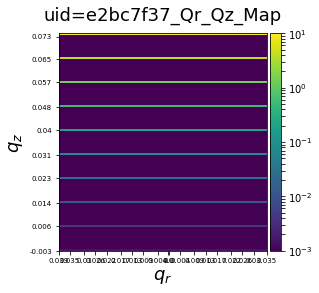

In [70]:
if scat_geometry =='gi_saxs':    
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

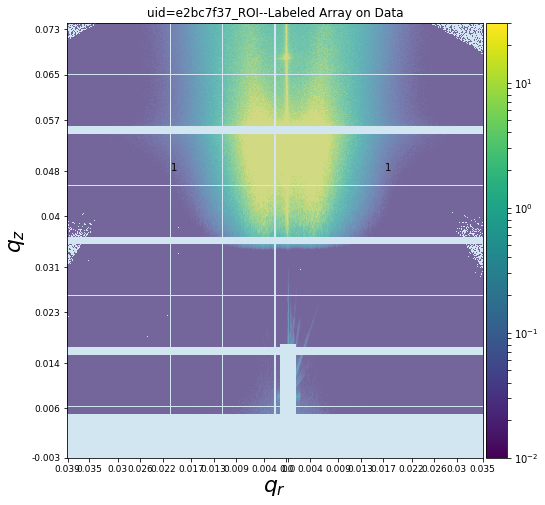

In [71]:
if scat_geometry =='gi_saxs':    
    #roi_masks, qval_dicts = get_gisaxs_roi( Qrs, Qzs, qr_map, qz_map, mask= mask )
    show_qzr_roi( avg_img, roi_masks, inc_x0, ticks[:4], alpha=0.5, save=True, path=data_dir, uid=uidstr )

In [72]:
md['incident angle']= md['inc_angle']

In [73]:
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/crosscor.py'
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Static_analysis_modified_for_CHX.py'
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Amplification_factors.py'

%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/autocor.py'
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/partitions.py'
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py'
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/nanoscope.py'


<Figure size 432x288 with 0 Axes>

# load everything above by doing "run above" in cell tab

# AFM analysis

In [246]:
from PIL import Image
p = read('/home/pmyint/AFM_images/sam2_si_bottom_1um.000')
p.height.process()
print(p.height.zrange, p.height.rms)
pixels = p.height.colorize()
bottom = Image.fromarray(pixels)

p = read('/home/pmyint/AFM_images/sam2_si_top_1um.000')
p.height.process()
print(p.height.zrange, p.height.rms)
pixels = p.height.colorize()
top = Image.fromarray(pixels)

p = read('/home/pmyint/AFM_images/sam2_si_right_1um.000')
p.height.process()
print(p.height.zrange, p.height.rms)
pixels = p.height.colorize()
right = Image.fromarray(pixels)

p = read('/home/pmyint/AFM_images/sam2_si_left_1um.000')
p.height.process()
print(p.height.zrange, p.height.rms)
pixels = p.height.colorize()
left = Image.fromarray(pixels)

p = read('/home/pmyint/AFM_images/sam2_si_cemter_1um.000')
p.height.process()
print(p.height.zrange, p.height.rms)
pixels = p.height.colorize()
center = Image.fromarray(pixels)

7.602195079185089 0.961739114379082
6.964084763897767 0.9669631028023431
6.185677455675233 0.8223590837110892
20.64866083572316 1.1322237580400614
8.168070571305176 1.0098630238842796


1.0098630238842825


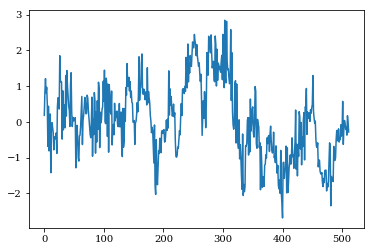

In [468]:
p = read('/home/pmyint/AFM_images/sam2_si_cemter_1um.000')
p.height.process()
image = p.height
data = image.data
# center = Image.fromarray(pixels)
plt.figure()
# plt.imshow(data)
plt.plot(data[:,200])
print(np.sqrt(np.mean(data**2)))
plt.show()

In [458]:
pixels.data

array([[-0.16350421, -0.1642182 , -0.08710705, ...,  0.69114443,
         0.7668276 ,  0.91962193],
       [-0.41268748, -0.49551057, -0.50122251, ..., -0.80823915,
        -0.81466508, -0.89677418],
       [-0.83751283, -0.68686048, -0.61260529, ...,  0.2191956 ,
         0.21633963,  0.13637251],
       ...,
       [-0.40054961, -0.16921615,  0.13780049, ..., -1.0781282 ,
        -0.84750872, -0.99958906],
       [ 0.091391  ,  0.091391  ,  0.01570783, ..., -1.37229298,
        -1.52580129, -1.60219846],
       [-0.02498973,  0.05212143, -0.02427573, ..., -1.13738955,
        -1.21378671, -1.21307272]])

In [452]:
 p.height.Rp + p.height.Rv

8.168070571305176

116.21739959716797


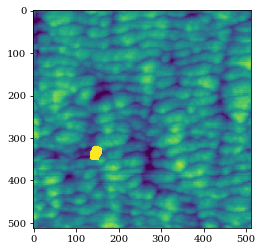

In [366]:
plt.figure()
plt.imshow(np.asarray(left)[:,:,0])
print(np.average(np.asarray(left)[:,:,0]))
plt.show()

2.9468052 10.656973


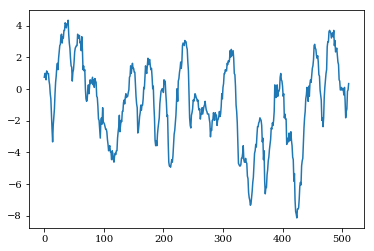

In [439]:
a = np.asarray(np.asarray(left)[:,:,0],dtype=np.float32)#[:,300]

a = a*(20/250)
a = a - np.sqrt(np.mean(a**2)) 
from scipy import stats
print(np.sqrt(np.mean(a**2)),np.max(a))
plt.figure()
# plt.imshow(a)
plt.plot(a[:,300])
# plt.plot(np.asarray(left)[:,:,0][:,300])
# plt.plot(np.asarray(left)[:,:,1][:,300])
# plt.plot(np.asarray(left)[:,:,2][:,300])
# print(np.average(np.asarray(left)[:,:,1][:,300]))
plt.show()

In [520]:
p = read('/home/pmyint/AFM_images/sam2_si_left_1um.000')
p.height.process()
print(p.height.zrange, p.height.rms)
pixels = p.height.height
# center_flatten = Image.fromarray(pixels)
# np.shape(center_flatten)
# plt.figure()
# plt.imshow(np.asarray(left)[:,:,0])
# print(np.average(np.asarray(left)[:,:,0]))
# plt.show()
np.shape(pixels)

20.64866083572316 1.1322237580400614


AttributeError: 'NanoscopeImage' object has no attribute 'height'

In [575]:
# np.exp(-1j *0.17082401254653182*pixels.data)
eee = pixels.data
np.shape(eee)

(512, 512)

In [526]:
1j + 2j

3j

In [714]:
# lattice_size=1024
# filename = '003newone'# '003newone_nonLin'
# range_to_avg_in_Y = [0,5]




 # Proper analysis below
 # declare the filenames and the filepath for analysis 
 # remember that once you load nanoscope.py it will overwrite the metadata previously loaded so get the correct calculation for the qs

In [82]:
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/nanoscope.py'

filename = 'sam2_si_right_1um.000'
filepath = '/home/pmyint/AFM_images/'

# lattice_size = 1024
datatakingtime = 1 #divide time unit by number of frames
latticeUnit_to_nm = 1000/512
qz_prime = 0.17082401254653182 ####
FD = single_lattice_image(filepath, filename, qz_prime) ####
number_of_images = 1
lattice_size = FD.lattice_size


md['eiger4m_single_cam_num_images'] = number_of_images
uid = filename
mask = np.ones((FD.lattice_size//2,FD.lattice_size//2))

2020-02-04 16:46:18.684265


<Figure size 720x445 with 0 Axes>

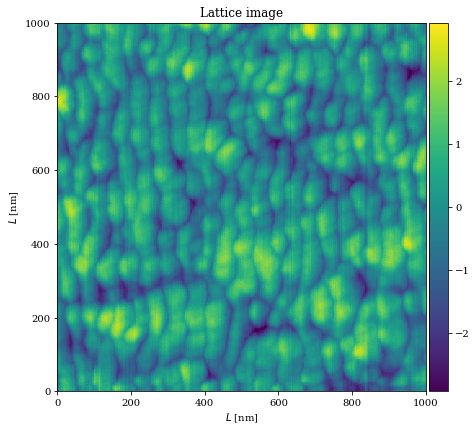

RMS of lattice image is  0.8223590837111376
Variance of lattice image is  0.6762744625621422


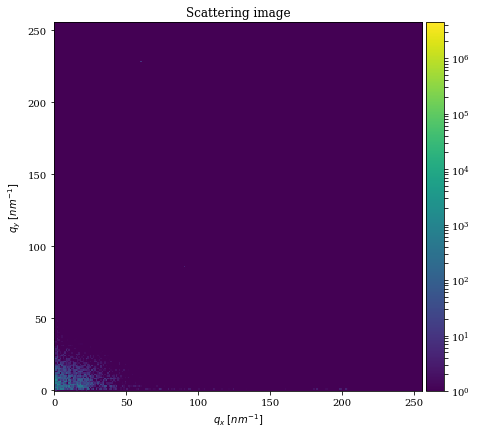

RMS of scattering image is  24328.51722224606
Max of scattering image is  8807860.81929284


<Figure size 504x504 with 0 Axes>

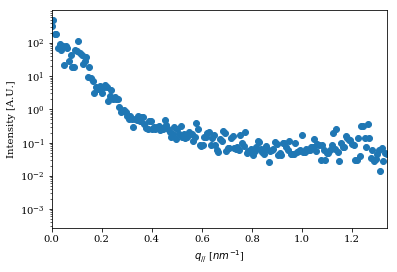

In [178]:
%matplotlib inline


plot_lattice_image([1])
plot_scattering_image([1],logscale=True,pixels=True)
# plot_lattice_image([100])
# plot_scattering_image([100],logscale=True)
yy = slice_scat_img(x=[1,215],y=[0,15])

# calculate the area underneath the S(q) curve, if the value is close to RMS roughness we are doing the FT correctly

In [167]:
(lattice_size)**2

262144

<Figure size 504x504 with 0 Axes>

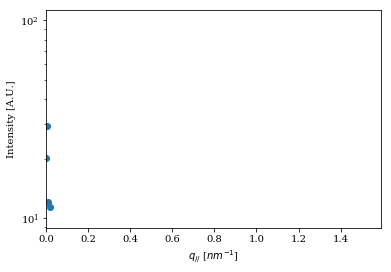

area = 0.8537875179272246
area = 0.8586016577829685


In [182]:
import numpy as np
from scipy.integrate import simps
from numpy import trapz

yy = slice_scat_img(x=[1,255],y=[1,255])
# The y values.  A numpy array is used here,
# but a python list could also be used.
# y = np.array([5, 20, 4, 18, 19, 18, 7, 4])

# Compute the area using the composite trapezoidal rule.
area = trapz(yy, dx=dx)
print("area =", area)

# Compute the area using the composite Simpson's rule.
area = simps(yy, dx=dx)
print("area =", area)

# Average over good AFM images to get the S(q) vs q

# Kr on Si

(512, 512)


<Figure size 720x445 with 0 Axes>

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


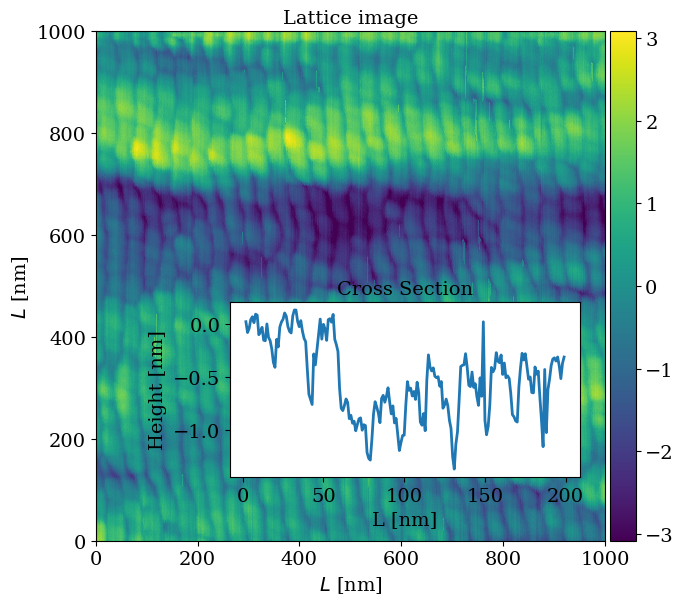

RMS of lattice image is  1.110225724613158
(512, 512)


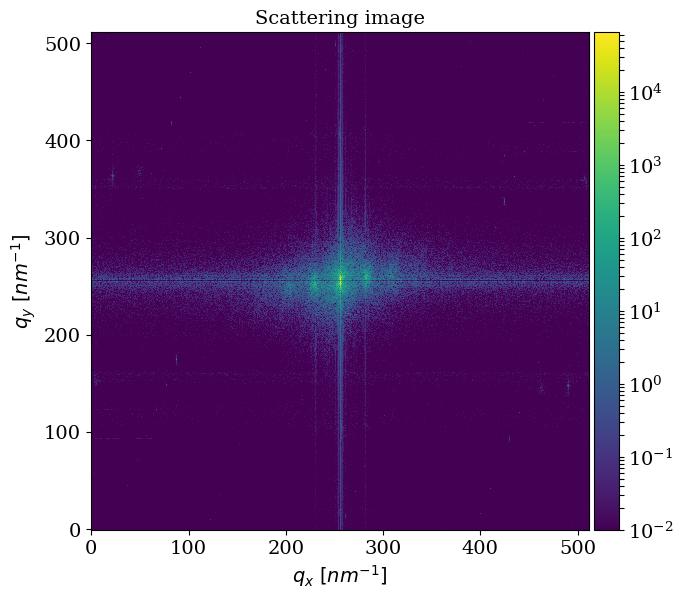

RMS of scattering image is  1.212081957709193
Max of scattering image is  66273.0003185987
Avg of scattering image is  1.212081957709193



qz and y_avg are -1.58 5


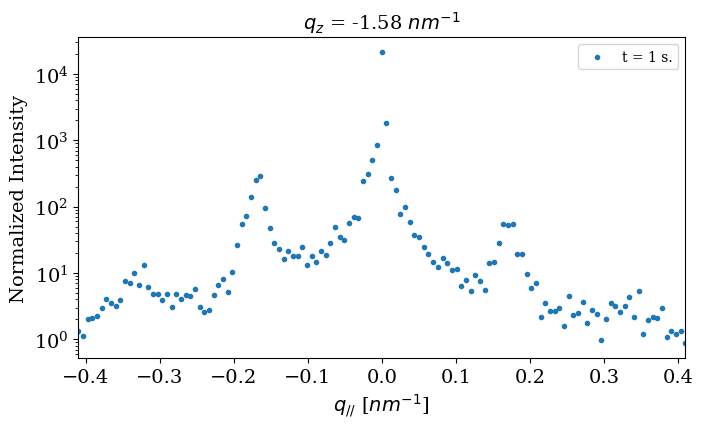

(512, 512)


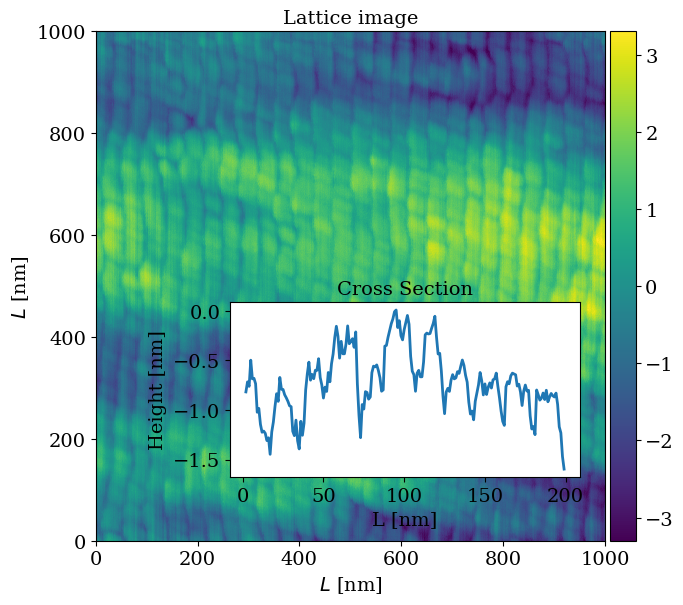

RMS of lattice image is  1.2313636962911527
(512, 512)


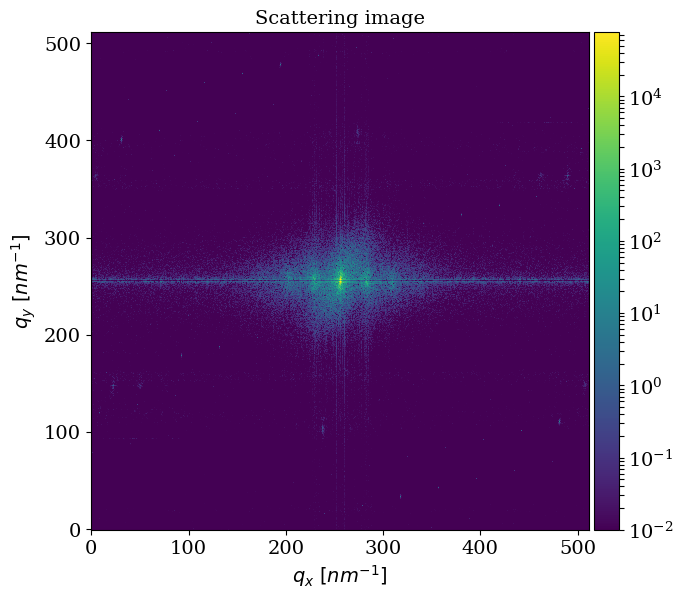

RMS of scattering image is  1.5046298630599273
Max of scattering image is  78014.4089693555
Avg of scattering image is  1.5046298630599273



qz and y_avg are -1.58 5


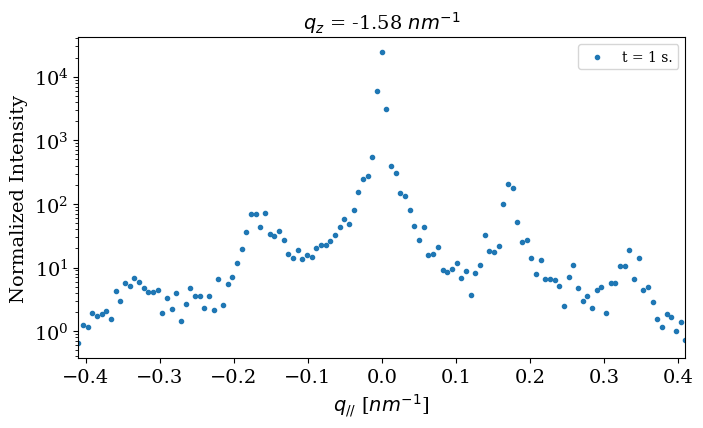

(512, 512)


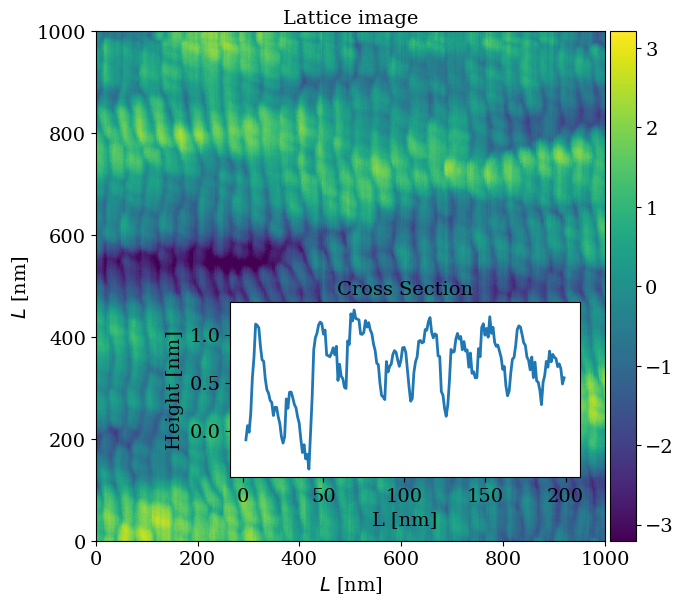

RMS of lattice image is  1.0180926754848165
(512, 512)


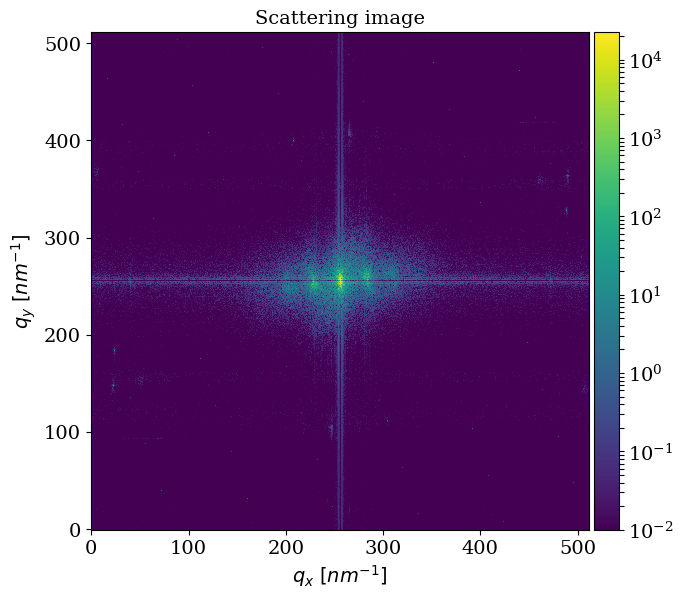

RMS of scattering image is  1.0394096025372055
Max of scattering image is  22556.416354586385
Avg of scattering image is  1.0394096025372055



qz and y_avg are -1.58 5


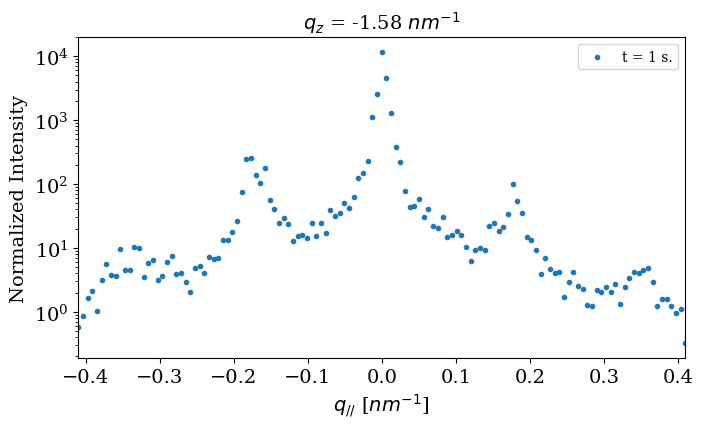

(512, 512)


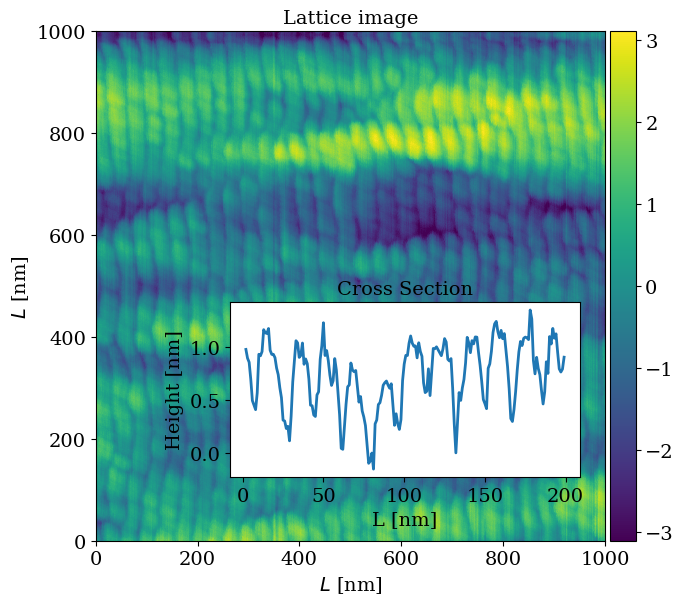

RMS of lattice image is  1.0810236711666916
(512, 512)


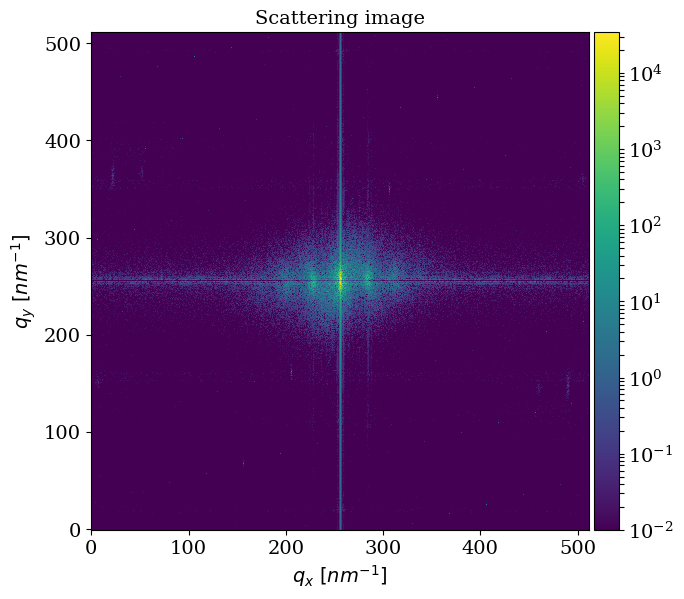

RMS of scattering image is  1.1548928479570302
Max of scattering image is  34628.64670255729
Avg of scattering image is  1.1548928479570302



qz and y_avg are -1.58 5


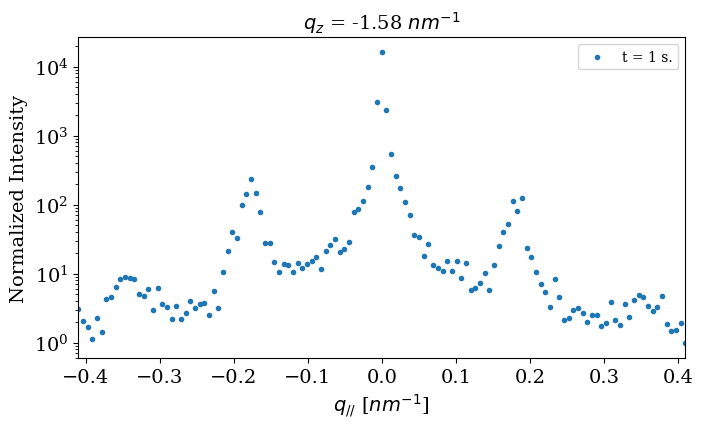

(512, 512)


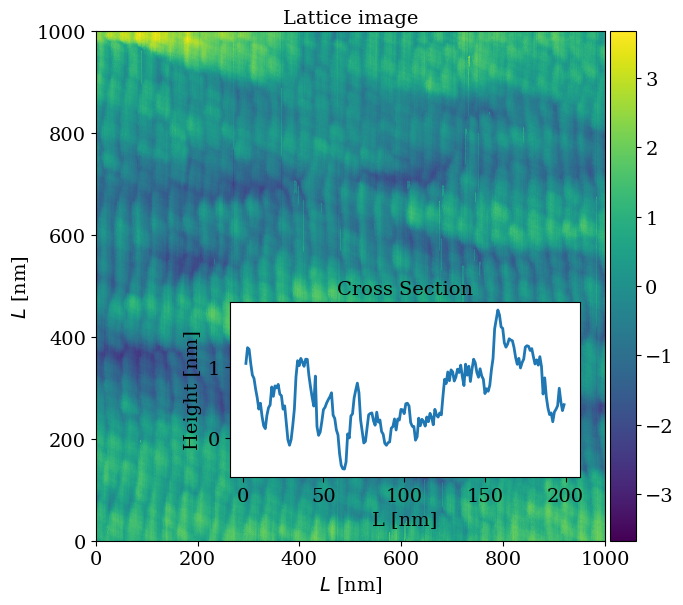

RMS of lattice image is  0.8536647752601396
(512, 512)


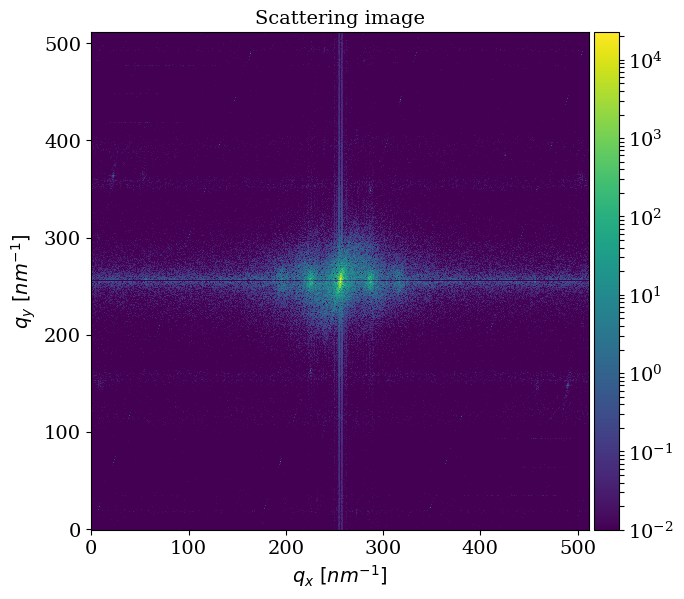

RMS of scattering image is  0.7252735115816958
Max of scattering image is  22642.53215610212
Avg of scattering image is  0.7252735115816958



qz and y_avg are -1.58 5


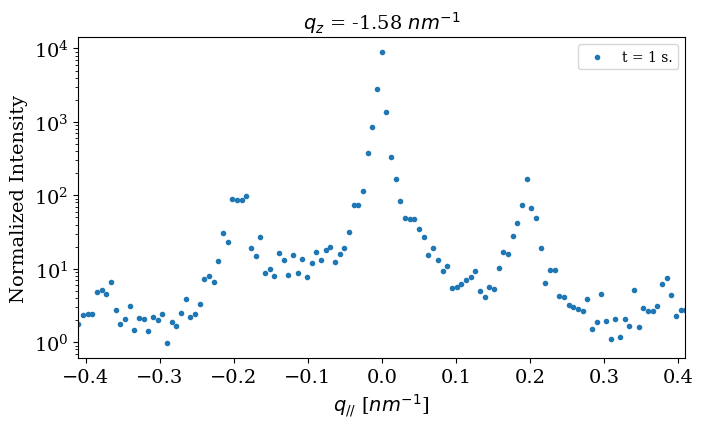

In [141]:
filenames = ['sam5_si_kr_bottom_1um.000', 'sam5_si_kr_center_1um.000', 'sam5_si_kr_left_1um.000', 'sam5_si_kr_right_1um.000', 'sam5_si_kr_top_1um.000']
# del uid # to save in the primary folder
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/nanoscope.py'

# %run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Static_analysis_modified_for_CHX.py'
sqs = []
for i in range(len(filenames)):
    filename = filenames[i]
    filepath = '/home/pmyint/AFM_images/'

    # lattice_size = 1024
    datatakingtime = 1 #divide time unit by number of frames
    latticeUnit_to_nm = 1000/512
    FD = single_lattice_image(filepath, filename,qz_prime)
    number_of_images = 1
    lattice_size = FD.lattice_size

#     if i == 4:
#         plot_lattice_image([1],slice = True, x = [2,200], y = [470,472], save = 1)
#     if i == 4:
    plot_lattice_image([1],slice = True, x = [2,200], y = [470,472], save = 0)
    plot_scattering_image([1],logscale=True, pixels=True)




#     %matplotlib inline
    qvals, sq, i_s, q_z,metadata = read_and_get_sq_q_at_different_t(select_frames = [], startframe = 1 , endframe = 2, frame_seperation = 1, bin_num = 1, xslice = [256-65,256+66],  yslice = [256-10,256] , SG = False, box_size  = 3, polynomial_order = 1, logscale = True)
    sqs.append(sq)  



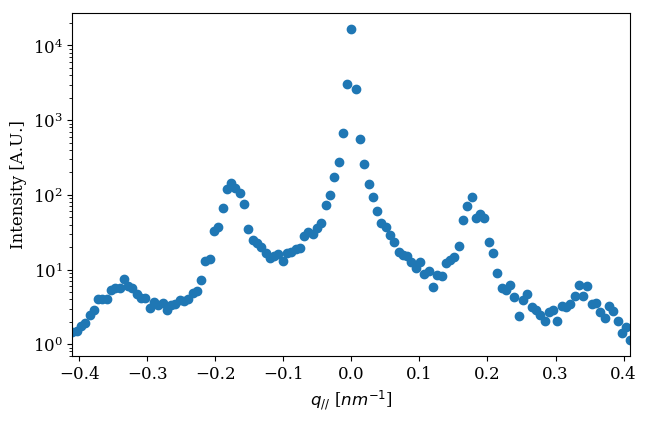

In [142]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.family'] = "serif"
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'figure.figsize': (7.2,4.45)})



sqs = np.asarray(sqs)
# np.shape(sqs)
sqs_avg = np.average(sqs, axis = 0)
plt.figure()#figsize= (7.2*1.5,4.45*1.5))
plt.scatter(qvals,sqs_avg)
# plt.title(r'$q_z$ = ' + np.str_(np.round(convert_pixel_to_q(0,y_avg)[2],decimals=2)) + r' $nm^{-1}$')
plt.ylabel('Intensity [A.U.]')
plt.xlabel(r'$q_{//}$ [$nm^{-1}$]')
# plt.legend(loc='best')
plt.xlim(qvals[0],qvals[-1])
if True:
#         plt.gca().set_ylim(1, 40000.0)
    plt.yscale('log')
plt.show()

# Ar on Si

(512, 512)


<Figure size 720x445 with 0 Axes>

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


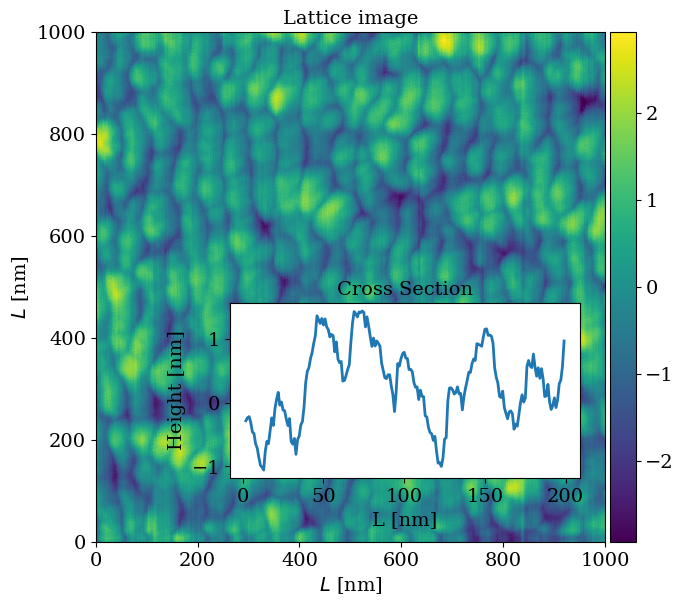

RMS of lattice image is  0.8223590837111376



qz and y_avg are -1.58 4


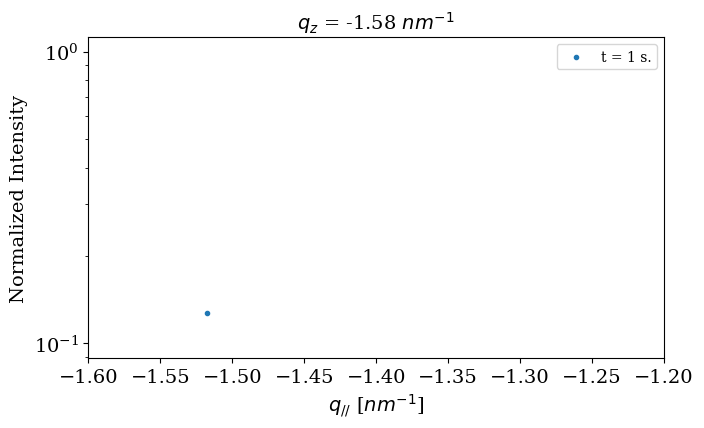


qz and y_avg are -1.58 4


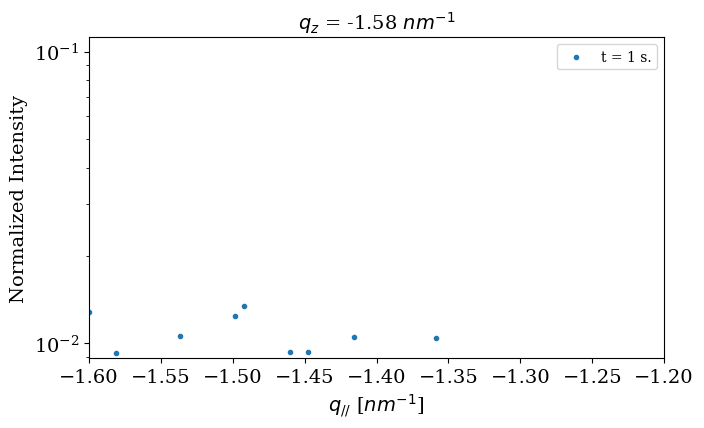


qz and y_avg are -1.58 4


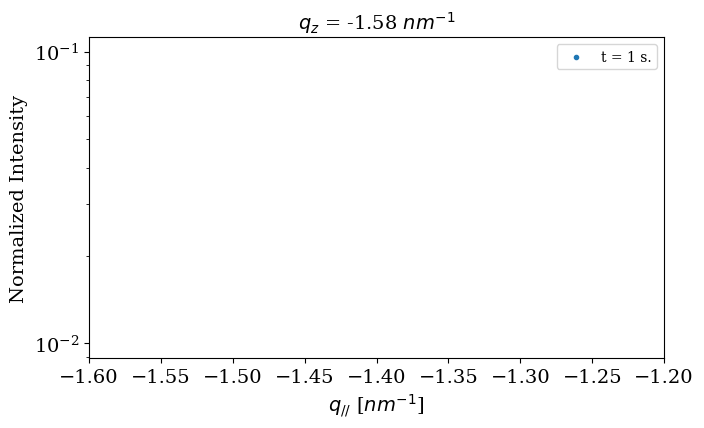

In [136]:
# del uid # to save in the primary folder
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/nanoscope.py'
filenames = ['sam2_si_left_1um.000','sam2_si_right_1um.000','sam2_si_top_1um.000','sam2_si_bottom_1um.000','sam2_si_cemter_1um.000']

filenames = ['sam2_si_right_1um.000','sam2_si_top_1um.000','sam2_si_bottom_1um.000'] #good files

# %run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Static_analysis_modified_for_CHX.py'
sqs = []
for i in range(len(filenames)):
    filename = filenames[i]
    filepath = '/home/pmyint/AFM_images/'

    # lattice_size = 1024
    datatakingtime = 1 #divide time unit by number of frames
    latticeUnit_to_nm = 1000/512
    FD = single_lattice_image(filepath, filename,qz_prime)
    number_of_images = 1
    lattice_size = FD.lattice_size

    if i == 0:
        plot_lattice_image([1],slice = True, x = [2,200], y = [502,503], save = 0)
#     if i == 0:
#         plot_lattice_image([1],show_subtitle = False, save=1)
#     plot_scattering_image([1],logscale=True, pixels=True)




#     %matplotlib inline
    qvals, sq, i_s, q_z,metadata = read_and_get_sq_q_at_different_t(select_frames = [], startframe = 1 , endframe = 2, frame_seperation = 1, bin_num = 1, xslice = [1,65],  yslice = [1,10] , SG = False, box_size  = 3, polynomial_order = 1, logscale = True)
    sqs.append(sq)    



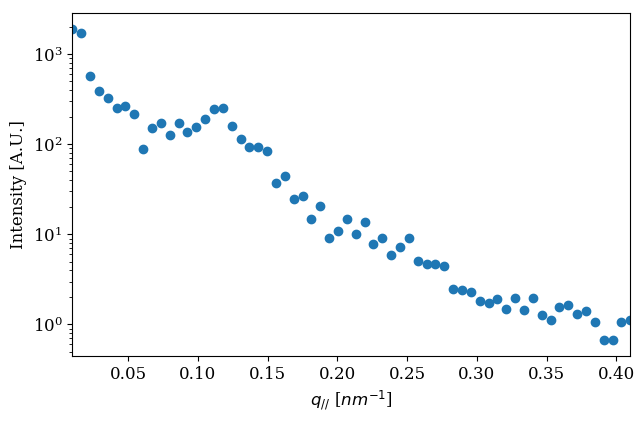

In [184]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.family'] = "serif"
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'figure.figsize': (7.2,4.45)})



sqs = np.asarray(sqs)
# np.shape(sqs)
sqs_avg = np.average(sqs, axis = 0)
plt.figure()#figsize= (7.2*1.5,4.45*1.5))
plt.scatter(qvals,sqs_avg)
# plt.title(r'$q_z$ = ' + np.str_(np.round(convert_pixel_to_q(0,y_avg)[2],decimals=2)) + r' $nm^{-1}$')
plt.ylabel('Intensity [A.U.]')
plt.xlabel(r'$q_{//}$ [$nm^{-1}$]')
# plt.legend(loc='best')
plt.xlim(qvals[0],qvals[-1])
if True:
#         plt.gca().set_ylim(1, 40000.0)
    plt.yscale('log')
plt.show()

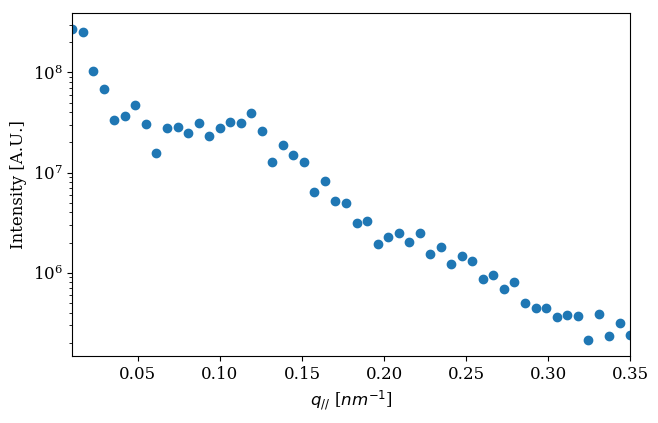

In [559]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.family'] = "serif"
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'figure.figsize': (7.2,4.45)})



sqs = np.asarray(sqs)
# np.shape(sqs)
sqs_avg = np.average(sqs, axis = 0)
plt.figure()#figsize= (7.2*1.5,4.45*1.5))
plt.scatter(qvals,sqs_avg)
# plt.title(r'$q_z$ = ' + np.str_(np.round(convert_pixel_to_q(0,y_avg)[2],decimals=2)) + r' $nm^{-1}$')
plt.ylabel('Intensity [A.U.]')
plt.xlabel(r'$q_{//}$ [$nm^{-1}$]')
# plt.legend(loc='best')
plt.xlim(qvals[0],qvals[-1])
if True:
#         plt.gca().set_ylim(1, 40000.0)
    plt.yscale('log')
plt.show()

In [186]:
pwd

'/home/pmyint'

In [188]:
np.save('qvals_AFM_20200129.npy',qvals)
np.save('sq_AFM_20200129.npy',sqs_avg)

<Figure size 720x445 with 0 Axes>

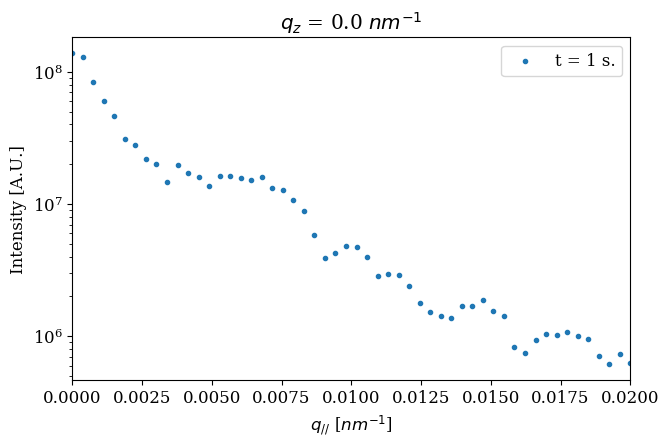

(array([0.        , 0.00037736, 0.00075472, 0.00113208, 0.00150943,
        0.00188679, 0.00226415, 0.00264151, 0.00301887, 0.00339623,
        0.00377358, 0.00415094, 0.0045283 , 0.00490566, 0.00528302,
        0.00566038, 0.00603774, 0.00641509, 0.00679245, 0.00716981,
        0.00754717, 0.00792453, 0.00830189, 0.00867925, 0.0090566 ,
        0.00943396, 0.00981132, 0.01018868, 0.01056604, 0.0109434 ,
        0.01132075, 0.01169811, 0.01207547, 0.01245283, 0.01283019,
        0.01320755, 0.01358491, 0.01396226, 0.01433962, 0.01471698,
        0.01509434, 0.0154717 , 0.01584906, 0.01622642, 0.01660377,
        0.01698113, 0.01735849, 0.01773585, 0.01811321, 0.01849057,
        0.01886792, 0.01924528, 0.01962264, 0.02      ]),
 array([1.39505339e+08, 1.29263587e+08, 8.36855084e+07, 6.02776830e+07,
        4.65776416e+07, 3.11784073e+07, 2.79269051e+07, 2.18843353e+07,
        1.99842327e+07, 1.46951043e+07, 1.96917552e+07, 1.72697059e+07,
        1.61010217e+07, 1.36655135e+07, 1.6396

In [501]:
center= [0, 0]
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Static_analysis_modified_for_CHX.py'
read_and_get_sq_q_at_different_t(select_frames = [], startframe = 1 , endframe = 2, frame_seperation = 1, bin_num = 1, xslice = [1,55],  yslice = [5,21] , SG = True, box_size  = 3, polynomial_order = 1, logscale = True)